Author：Author: Ziyuan Li, 12211225
Date: 2024 Nov 30

This document is created as a report for SDM274, Sustech.

# 1. Preparing the data for fit


In [1]:
from nonlin import complex_nonlin_func
from modules import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Prepare the data for fitting
x = np.linspace(-10, 10, 500)
y = complex_nonlin_func(x)

# add noise to the data
y = y + 0.2 * np.random.normal(size=x.size)

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42)

trained = False


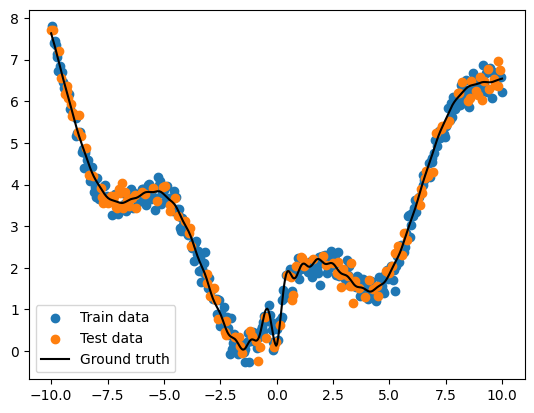

In [8]:
# plot the data

plt.scatter(X_train, y_train, label='Train data')
plt.scatter(X_test, y_test, label='Test data')
plt.plot(x, complex_nonlin_func(x), label='Ground truth', color='black')
plt.legend()
plt.show()


In [ ]:
def mse_loss(predicted, target):
    # Reshape target to match predicted's shape
    target = target.reshape(predicted.shape)
    return np.mean((predicted - target) ** 2)

def mse_loss_grad(predicted, target):
    # Reshape target to match predicted's shape for gradient calculation
    target = target.reshape(predicted.shape)
    return 2 * (predicted - target) / predicted.shape[0]


# 2. Designing the MLP

In [9]:
# construct the MLP model

class MLP(Module):
    def __init__(self, layers, epochs=1000, lr=0.01, input_shape = 1, output_shape = 1):
        super().__init__()
        self.layers = layers
        self.epochs = epochs
        self.lr = lr
        self.loss = []
        self.input_shape = input_shape
        self.ouatput_shape = output_shape
        
        
    def forward(self, X):
        A = X  # input layer, caches the input
        for layer in self.layers:
            A = layer.forward(A)
        
        return A
    
    def backward(self, dA):
        dZ = dA 
        # again we externally call the last layer
        for layer in reversed(self.layers):
            dZ = layer.backward(dZ)
        
    def update_params(self, lr):
        for layer in self.layers:
            if isinstance(layer, Linear):
                layer.W -= lr * layer.parameters['dW']
                layer.b -= lr * layer.parameters['db']

    def predict(self, X):
        A = X
        for layer in self.layers[:-1]:
            A = layer.forward(A)
        # 
        return A
                
    def train_BGD(self, X, Y, epochs=None, lr=None):
        if epochs is None:
            epochs = self.epochs
        if lr is None:
            lr = self.lr

        # expands X to (m, features) 
        # feature number here is coded in self.input_shape
        X = X.reshape(-1, self.input_shape)

        for epoch in range(epochs):
            
            # forward pass
            # it iterates all the layers except the last one
            A = self.forward(X)
            
            # compute the loss using the MSE layer
            loss = self.layers[-1].forward(A, Y)
            self.loss.append(loss)

            # backward pass using the MSE layer
            dA = self.layers[-1].backward(A, Y)
            self.backward(dA)
            
            # update the parameters
            self.update_params(lr)
            
            # Print loss every 50 epochs
            if epoch % 50 == 0:
                print(f'Epoch {epoch}, Loss: {loss}')
    

              
                

In [10]:
layers = [
    Linear(input_size=1, output_size=10),
    ReLU(),
    Linear(input_size=10, output_size=10),
    ReLU(),
    Linear(input_size=10, output_size=1),
    MSE()
]

# 3. Training the MLP Model

In [11]:
# Create    
mlp_model = MLP(layers, epochs=8000, lr=0.05)

# Train the model with the generated data
mlp_model.train_BGD(X_train, y_train)

TypeError: forward() missing 1 required positional argument: 'target'

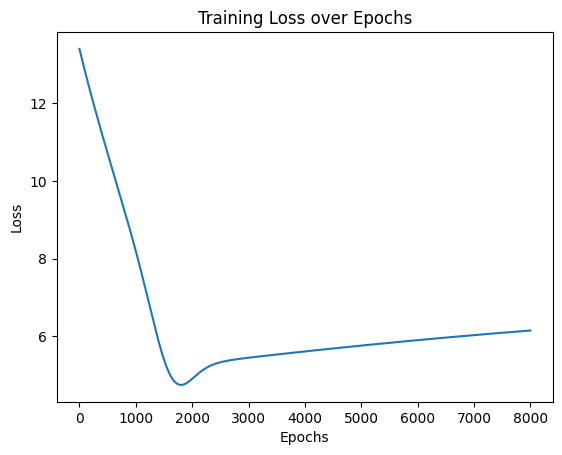

In [ ]:
plt.plot(mlp_model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()